In [91]:
import pulser
import pulser_simulation

import matplotlib.pyplot as plt
import numpy as np
import qutip
import itertools

# 0) Demonstrating Rydberg blockade
https://pulser.readthedocs.io/en/stable/intro_rydberg_blockade.html

### Build register with any arrangment of atoms

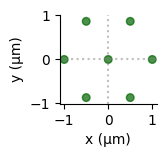

In [3]:
register = pulser.Register.hexagon(
    layers=1,    # atom layers surrounding central
    spacing=1.0  # between atoms, in um
)
register.draw(with_labels=False)

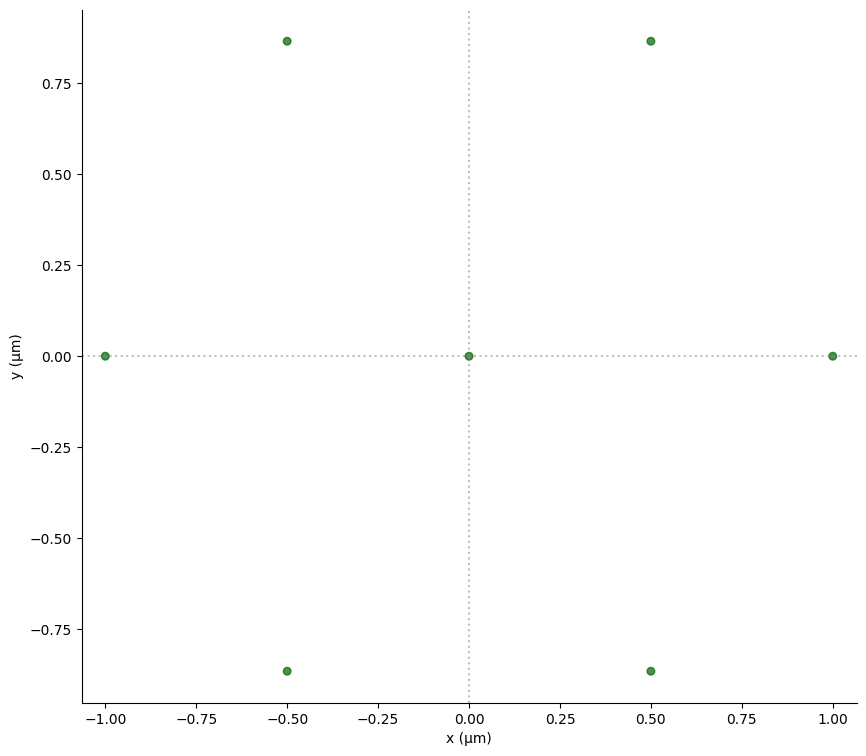

In [7]:
# Draw a larger graph...
fig = plt.figure(figsize=(10, 9))
ax = plt.gca()
register.draw(custom_ax=ax, with_labels=False, draw_graph=False, blockade_radius=10)

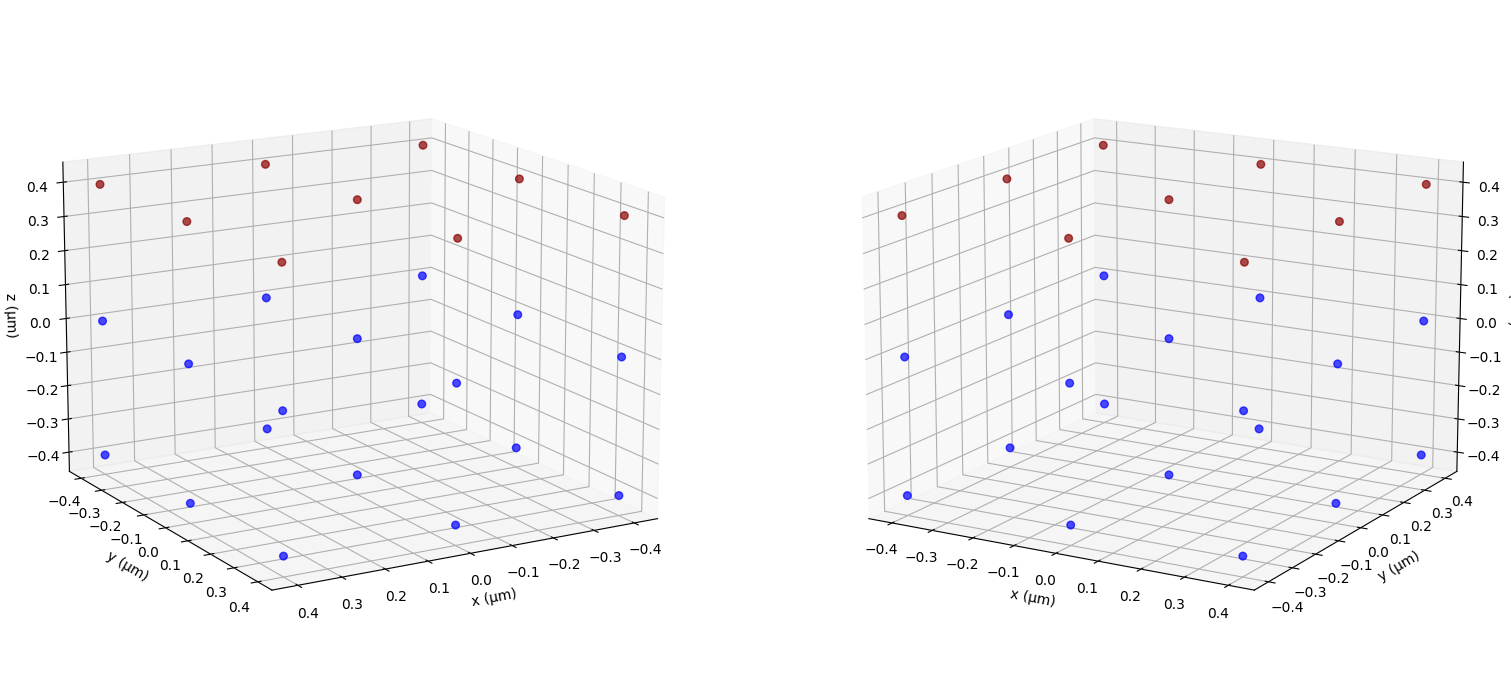

In [19]:
# Cubic arrangement
cube_register = pulser.Register3D.cubic(
    side=3,       # number of atoms per side
    spacing=0.4,  # between atoms in um
)
qubit_colors = {}
for idx, (x, y, z) in cube_register.qubits.items():
    qubit_colors[idx] = "darkred" if z > 0 else "blue"
cube_register.draw(qubit_colors=qubit_colors)

### Addendum: image > edge representation > positions of edge points > atom arrangement

In [11]:
from PIL import Image, ImageFilter

# try cv2: https://stackoverflow.com/questions/50274063/find-coordinates-of-a-canny-edge-image-opencv-python

In [89]:
mona_lisa = Image.open("mona-lisa.png")
mona_lisa = mona_lisa.convert("L")
mona_lisa.filter(ImageFilter.FIND_EDGES)
mona_lisa;

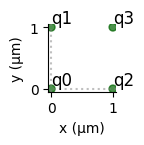

In [52]:
custom_register = pulser.Register(
    qubits={
        "q0": np.array([0, 0]),
        "q1": np.array([0, 1]),
        "q2": np.array([1, 0]),
        "q3": np.array([1, 1]),
    }
)
custom_register.draw()

### Design pulse to operate on atoms 

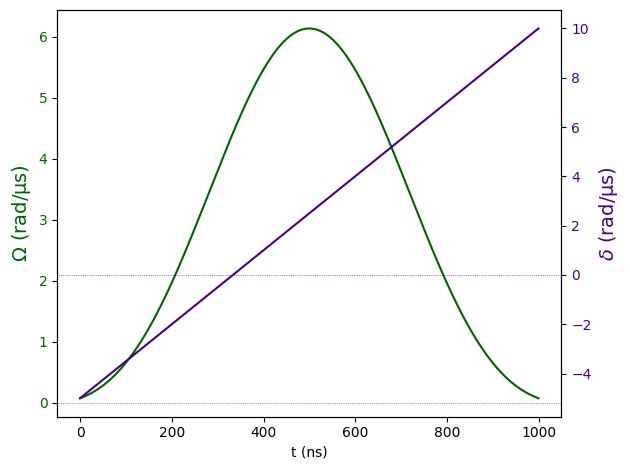

In [46]:
pulse_duration = 1000  # in ns
amplitude = pulser.waveforms.KaiserWaveform(
    duration=pulse_duration,
    beta=2 * np.pi,
    area=3,
)
detuning = pulser.waveforms.RampWaveform(duration=pulse_duration, start=-5.0, stop=10.0)
pulse = pulser.Pulse(amplitude=amplitude, detuning=detuning, phase=0)
pulse.draw()

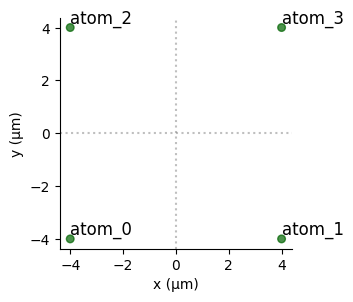

available device channels: rydberg_global rydberg_local raman_local


In [47]:
# 0) Define register, pulse waveform, and pulse sequence
register = pulser.Register.rectangle(rows=2, columns=2, spacing=8.0, prefix="atom_")
register.draw()

pulse = pulser.Pulse.ConstantDetuning(amplitude=amplitude, detuning=0, phase=0)

sequence = pulser.Sequence(
    register=register,
    device=pulser.devices.Chadoq2,
)
print("available device channels:", *sequence.available_channels.keys())

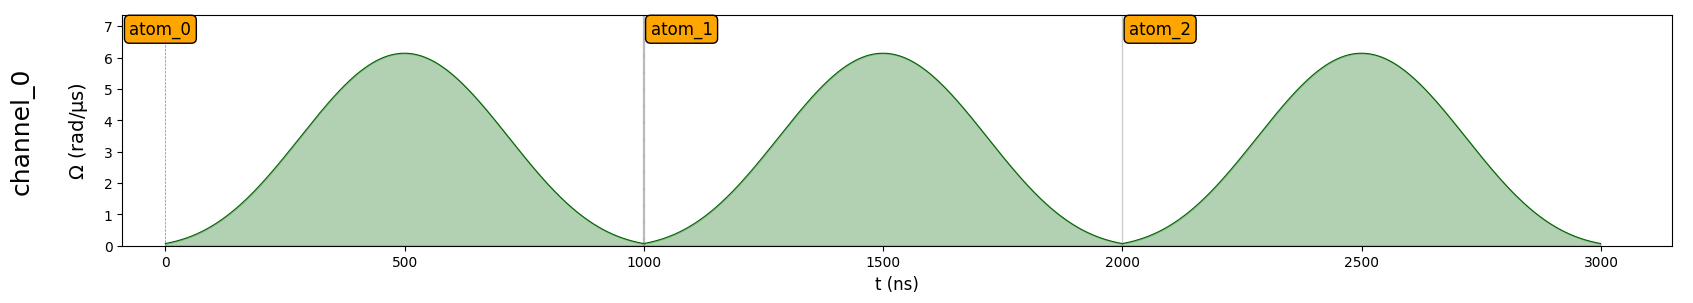

In [48]:
# 1) Declare channel (and implicitly target an atom for subsequent pulses)
sequence.declare_channel(name="channel_0", channel_id="rydberg_local", initial_target="atom_0")
sequence.add(pulse, "channel_0")  # appends pulse to the end of a schedule

# 2) Target channel to another atom for subsequent pulses
sequence.target(qubits="atom_1", channel="channel_0")
sequence.add(pulse, "channel_0")

# 3) Target a third atom...
sequence.target(qubits="atom_2", channel="channel_0")
sequence.add(pulse, "channel_0")

sequence.draw()

In [49]:
# Explore Rydberg blockade by sweeping distance between adjacent atoms
spacings = np.linspace(
    start=4,  # um
    stop=10,  # um
    num=10,
)
data = []

# Define the operator to get the expectation for, here the outer product of the excited state with itself
excited = np.array([1, 0])  # excited state 
collective_excited = np.kron(excited, excited)
occupation = [np.outer(collective_excited, np.conj(collective_excited))]  # rr @ rr ?

for idx, spacing in enumerate(spacings):
    register = pulser.Register.rectangle(rows=1, columns=2, spacing=spacing, prefix="atom_")
    sequence = pulser.Sequence(register, pulser.devices.Chadoq2)
    sequence.declare_channel(name="channel_0", channel_id="rydberg_local", initial_target="atom_0")
    sequence.add(pulse, "channel_0")
    sequence.target(qubits="atom_1", channel="channel_0")
    sequence.add(pulse, "channel_0")
    
    simulator = pulser_simulation.Simulation(sequence)
    
    result = simulator.run()
    data.append(result.expect(occupation)[0])  # expectation value for given operator

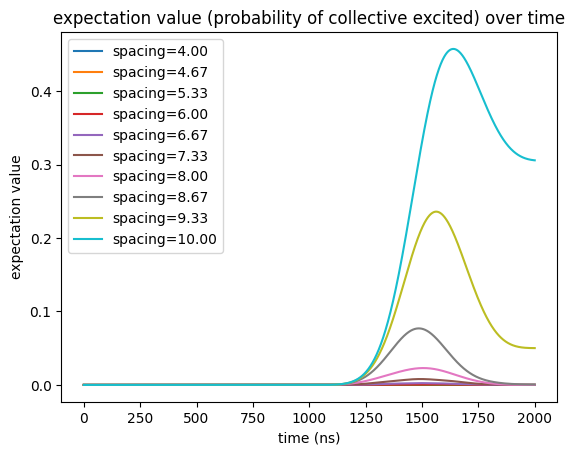

In [50]:
# Demonstrate Rydberg blockade: given an atom excited by a pulse, a nearby atom can't be subsequently excited
# (with the same pulse -- I wonder, try a different pulse?)
for idx, expectation_values in enumerate(data):
    plt.plot(expectation_values, label=f"spacing={spacings[idx]:.2f}")
plt.title("expectation value (probability of collective excited) over time")
plt.xlabel("time (ns)")
plt.ylabel("expectation value")
plt.legend()

# 1) CZ gate pulse sequence
https://pulser.readthedocs.io/en/stable/tutorials/cz_gate.html

### Load register onto device

Selected Rydberg blockade radius: 6 µm


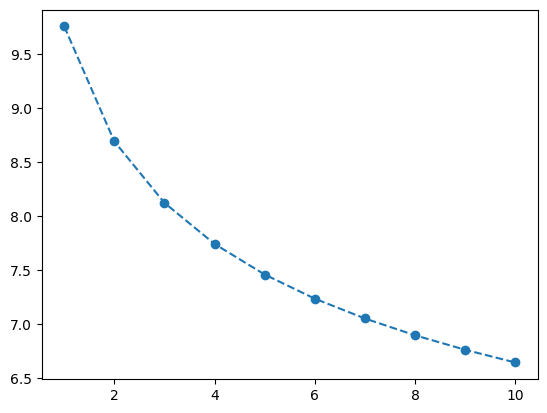

In [164]:
# Select Rydberg blockade radius
frequency_sweep = np.linspace(start=1, stop=10, num=10)
rydberg_blockade_radii = [
    pulser.devices.Chadoq2.rydberg_blockade_radius(
        rabi_frequency=2.0 * np.pi * frequency
    )
    for frequency in frequency_sweep
]

plt.figure()
plt.plot(frequency_sweep, rydberg_blockade_radii, "--o")

RYDBERG_BLOCKADE_RADIUS = int(rydberg_blockade_radii[-1])
print("Selected Rydberg blockade radius:", RYDBERG_BLOCKADE_RADIUS, "µm")

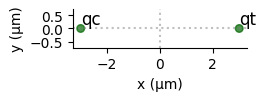

In [143]:
# Place atoms within Rydberg blockade radius of each other (so that we can interact them)
register = pulser.Register(
    qubits={
        "qc": np.array([-rydberg_blockade_radius / 2, 0.0]),
        "qt": np.array([rydberg_blockade_radius / 2, 0.0]),
    }
)
register.draw()

In [141]:
def prepare_state(state_id, basis_state_name):
    """Given label, gets state for a neutral atom qubit.
    
    Three possible basis (?) states are: digital (ground-hyperfine occupied), ground-rydberg occupied, and all
    (ground-rydberg-hyperfine occupied). Hyperfine and ground levels encode the 0 and 1 states respectively.
    The ground level is coupled to a highly excited Rydberg level.
    """
    assert len(state_id) in (2, 3), "must occupy two or three levels."
    basis_state_name_to_state_id = {"digital": "gh", "ground-rydberg": "rg", "all": "rgh"}
    assert basis_state_name in basis_state_name_to_state_id, f"basis '{basis_state_name}' is not valid."
    
    # Take product of specified basis state ID with itself N times where N is the number of occuppied levels
    possible_state_ids = {
        "".join(x)
        for x in itertools.product(basis_state_name_to_state_id[basis_state_name], repeat=len(state_id))
    }
    assert state_id in possible_state_ids, f"state ID {state_id} is not valid."
    
    # Get tensor product state from state ID label (e.g., "ab" -> a ⊗ b)
    states = {
        op: qutip.basis(len(basis_state_name_to_state_id[basis_state_name]), idx)
        for idx, op in enumerate(basis_state_name_to_state_id[basis_state_name])
    }
    return states, qutip.tensor([states[atom] for atom in state_id])


def build_state_from_id(s_id, basis_name):
    if len(s_id) not in {2, 3}:
        raise ValueError("Not a valid state ID string")

    ids = {"digital": "gh", "ground-rydberg": "rg", "all": "rgh"}
    if basis_name not in ids:
        raise ValueError("Not a valid basis")

    pool = {"".join(x) for x in itertools.product(ids[basis_name], repeat=len(s_id))}
    if s_id not in pool:
        raise ValueError("Not a valid state id for the given basis.")

    ket = {
        op: qutip.basis(len(ids[basis_name]), i)
        for i, op in enumerate(ids[basis_name])
    }
    if len(s_id) == 3:
        # Recall that s_id = 'C1'+'C2'+'T' while in the register reg_id = 'C1'+'T'+'C2'.
        reg_id = s_id[0] + s_id[2] + s_id[1]
        return qutip.tensor([ket[x] for x in reg_id])
    else:
        return qutip.tensor([ket[x] for x in s_id])

### Define CZ state preparation pulse sequence

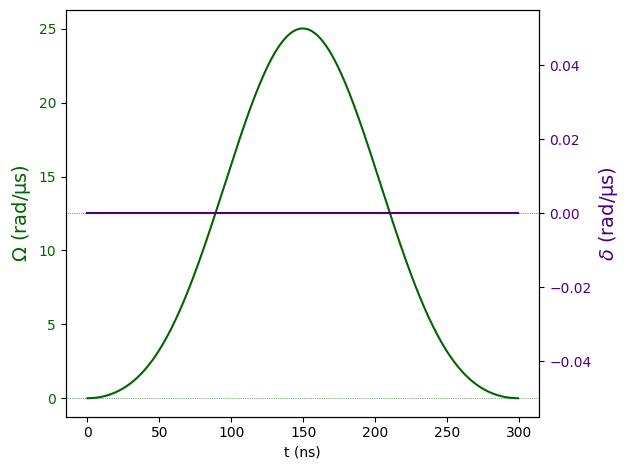

In [161]:
# Define π-pulse for exciting atoms to hyperfine state
pulse_duration = 300  # ns
PI_PULSE_Y = pulser.Pulse.ConstantDetuning(
    pulser.waveforms.BlackmanWaveform(duration=pulse_duration, area=np.pi), detuning=0.0, phase=-np.pi / 2, 
)
PI_PULSE_Y.draw()

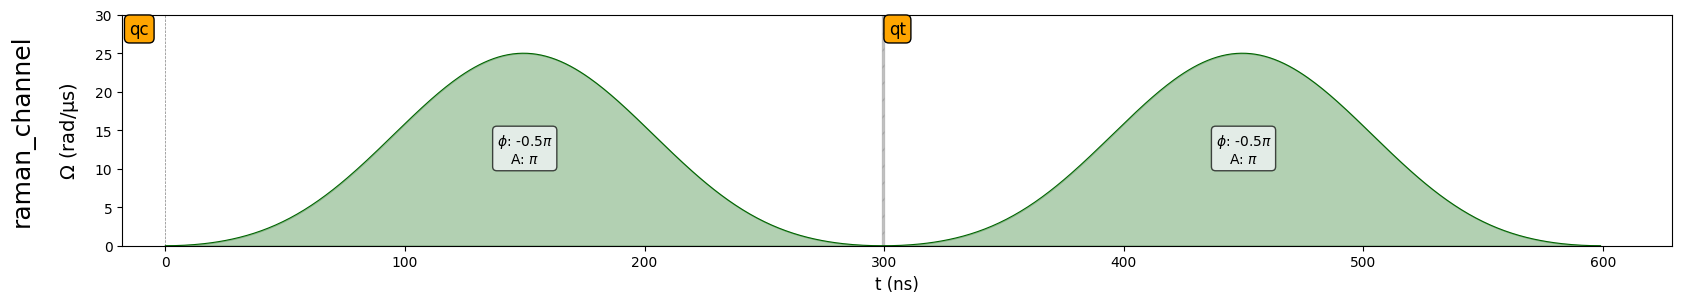

In [186]:
def prepare_cz_sequence(state_id):
    """Prepare CZ sequence object for a given initial state."""
    # Define register for qubit arrangement and sequence object; get qubit IDs
    register = pulser.Register(
        qubits={
            "qc": np.array([-RYDBERG_BLOCKADE_RADIUS / 2, 0.0]),
            "qt": np.array([RYDBERG_BLOCKADE_RADIUS / 2, 0.0]),
        }
    )
    sequence = pulser.Sequence(register, pulser.devices.Chadoq2)
    control_id, target_id = register.qubit_ids
    
    if set(state_id) == {"g"}:
        basis_state_name = "ground-rydberg"
        print(
            f"Warning: {state_id} needs no preparation, as atoms are already initialized in ground state."
        )
    else:
        basis_state_name = "all"
        control, target = state_id

        # Add control pulse
        control_channel = "raman_channel"
        sequence.declare_channel(name=control_channel, channel_id="raman_local", initial_target=control_id)
        if control == "h":
            sequence.add(PI_PULSE_Y, channel=control_channel)

        # Add target pulse
        if target == "h":
            sequence.target(qubits=target_id, channel=control_channel)
            sequence.add(PI_PULSE_Y, channel=control_channel)

    # Confirm that state ID is valid for the two-qubit control-target register.
    preparation_state = build_state_from_id(state_id, basis_state_name)
    return preparation_state, sequence, register


preparation_state, cz_sequence, register = prepare_cz_sequence("hh")
cz_sequence.draw(draw_phase_area=True)

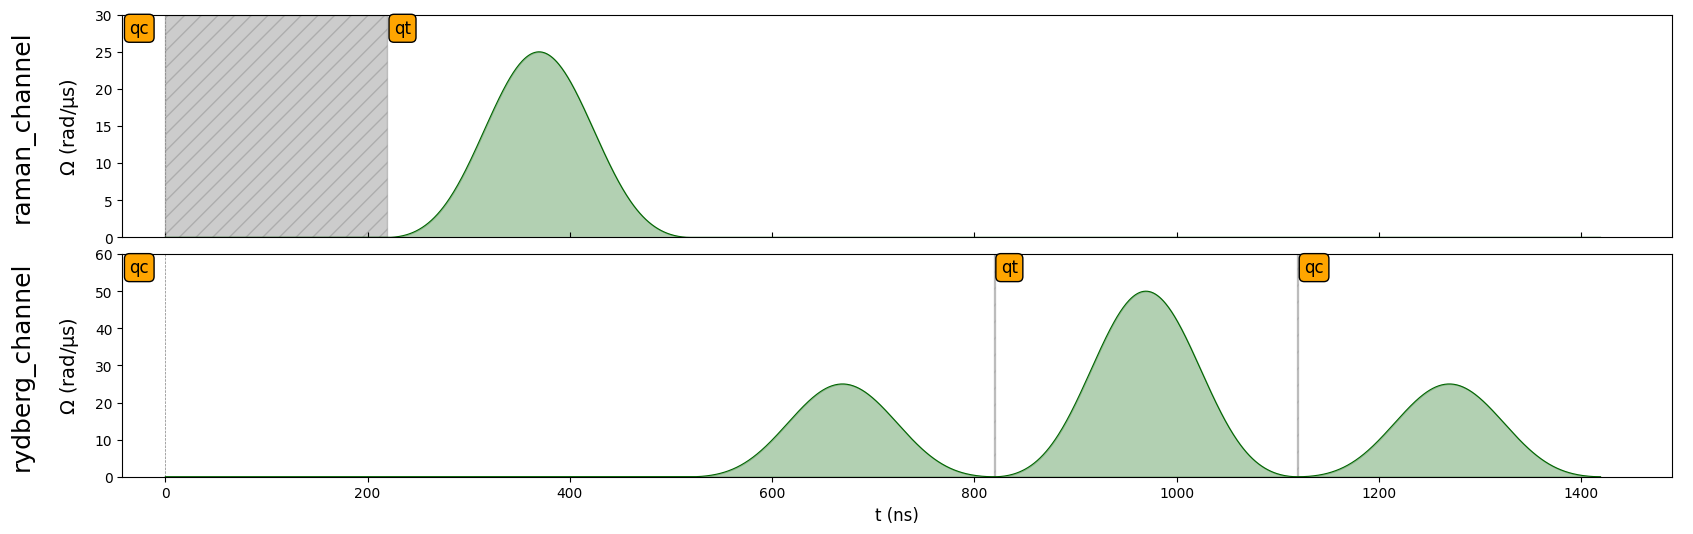

In [189]:
def build_cz_sequence(initial_state_id=None):
    """Builds CZ sequence (with an optional initial state)."""
    # Define pulses for building CZ sequence
    PI_PULSE = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.BlackmanWaveform(duration=pulse_duration, area=np.pi),
        detuning=0.0,
        phase=0.0, 
    )
    TWOPI_PULSE = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.BlackmanWaveform(duration=pulse_duration, area=2 * np.pi),
        detuning=0.0,
        phase=0.0, 
    )
    
    # Initialize CZ sequence and preparation time (when subsequent pulse must begin).
    if initial_state_id is None:
        initial_state_id = "gg"
    preparation_state, sequence, register = prepare_cz_sequence(initial_state_id)
    preparation_time = max(
        (
            sequence._last(channel).tf                    # gets stop time of latest pulse in channel 
            for channel in cz_sequence.declared_channels
        ),
        default=0
    )
    
    # Add pulses to CZ sequence
    control, target = register.qubit_ids
    target_channel = "rydberg_channel"
    sequence.declare_channel(name=target_channel, channel_id="rydberg_local", initial_target=control)
    sequence.add(
        PI_PULSE,
        channel=target_channel,
        protocol="wait-for-all",  # waits for state preparation
    )
    sequence.target(qubits=target, channel=target_channel)
    sequence.add(TWOPI_PULSE, channel=target_channel)
    sequence.target(qubits=control, channel=target_channel)
    sequence.add(PI_PULSE, channel=target_channel)
    return sequence, preparation_state, preparation_time

cz_sequence, preparation_state, preparation_time = build_cz_sequence(initial_state_id="gh")
cz_sequence.draw()